# Shortest Path Template

## Introduction to the shortest path problem

The shortest path problem's goal is to figure out the shortest path from an origin node to a destination node. 
There are several inputs used toward solving such problem: 
- 1) build the network, and set the weight for each link
- 2) formulate the objective function and add constraints to find out the shortest path 
- 3) visualize the traffic network of the shortest path

## Problem 1
### Problem Statement
In the transportation network, the inflow comes from the origin Node 1, and the outflow comes out at the destination Node 6. The travel time parameters from node $i$ to node $j$ is $t_{ij}$. **What is the shortest travel time in the network from origin to destination?**

![jupyter](./prob1.jpg)

#### Decision Variables
  ##### Variables of path  $x_{ij}$
* $x_{12}$= the link from node 1 to node 2 
* $x_{13}$= the link from node 1 to node 3
* $x_{23}$= the link from node 2 to node 3
* $x_{24}$= the link from node 2 to node 4
* $x_{25}$= the link from node 2 to node 5
* $x_{35}$= the link from node 3 to node 5
* $x_{46}$= the link from node 4 to node 6
* $x_{54}$= the link from node 5 to node 4
* $x_{56}$= the link from node 5 to node 6

### Objective function
Minimize $Z = \sum t_{ij}\cdot x_{ij}$\
  i.e., $Z = t_{12}\cdot x_{12}+t_{13}\cdot x_{13}+t_{23}\cdot x_{23}+t_{24}\cdot x_{24}+t_{25}\cdot x_{25}+t_{35}\cdot x_{35}+t_{46}\cdot x_{46}+t_{54}\cdot x_{54}+t_{56}\cdot x_{56}$

#### Node constraints
* Origin: Node 1 \
$ Input = x_{12}+x_{13}$
* Destination: Node 1 \
$x_{46}+x_{56} = Output $
* Node 2\
$x_{12}= x_{23}+ x_{24}+ x_{25}$
* Node 3\
$x_{13}+ x_{23} = x_{35}$
* Node 4\
$x_{24}+ x_{54} = x_{46}$
* Node 5\
$x_{25}+ x_{35} = x_{54} +x_{56}$

### Method 1 : Solution by Python Pulp Package
Formulate the network: build the nodes and connnect each nodes with a path.

In [1]:
# Import PuLP modeler functions
from pulp import *
# Data for Linear Optimization Problem
N = 6  # Number of nodes in network
M = 2  # number of end nodes (source and sink or origin and destination)
INT = 4 # Number of intermediate nodes
a = range(1, N+1)
al = range(N)
b = range(1,N+1)
bl = range(N)
# Index list for decision variables x
xindx = [(a[i],b[j]) for j in bl for i in al]
T = INT + M # number of artificial variables (y)
tindx = range(1, T+1)

Add decision variables and formulate objective function of the total travel time.

In [2]:
model = LpProblem("Shortest_Path_Problem",LpMinimize)
# Decision variables
x = LpVariable.dicts("X", xindx,0,None)
y = LpVariable.dicts("Y", tindx,0,None)
model+= 2.0*x[1,2] +4.0*x[1,3] + 4.0*x[2,4] + 1.0*x[2,3] + 2.0*x[2,5] + 10.0*x[3,5]+ 3.0*x[5,4]+2.0*x[4,6] + 2.0*x[5,6], "Transportation cost"

Add constraints for each node: the source node and destination node have a netflow of 1, other intermediate flow have a balanced inflow and outflow.

In [3]:
model += x[1,2] + x[1,3] -y[1] == 1,"Source node"
model += x[4,6] + x[5,6] -y[2] == 1,"Destination node"
model += x[1,2] - x[2,3] - x[2,4] - x[2,5] - y[3] == 0,"Node 2"
model += x[1,3] - x[2,3] - x[3,5] - y[4] == 0,"Node 3"
model += x[2,4] + x[5,4] - x[4,6] - y[5] == 0, "Node 4"
model += x[2,5] + x[3,5] - x[5,4] - x[5,6] - y[6] == 0, "Node 5"

Solv the model and check the optimal status and find out the shortest path

In [4]:
model.solve()
print('Status:',LpStatus[model.status])

Status: Optimal


In [5]:
for v in model.variables():
    if v.varValue==1:
        print(v.name, '=', v.varValue)

X_(1,_2) = 1.0
X_(2,_5) = 1.0
X_(5,_6) = 1.0


The shortest path from node_1 to node_6 is 1->2->5->6

In [6]:
#Print the optimized value of the objective function
print('The value of objective function is',value(model.objective))
print('the shortest travel time is', value(model.objective))

The value of objective function is 6.0
the shortest travel time is 6.0


### Method 2 : Solution by Python NetworkX package

In [6]:
import networkx as nx

Initializing the Network

In [7]:
# The following line initializes an empty directed graph objects
G1=nx.DiGraph()

In [8]:
G1.add_node(1)
G1.add_node(2)
G1.add_node(3)
G1.add_node(4)
G1.add_node(5)
G1.add_node(6)
G1.nodes()

NodeView((1, 2, 3, 4, 5, 6))

Construct the network with weighted edges

In [9]:
G1.add_edge(1, 2, weight = 2.0)
#G1.add_edge(1,3)
#G1[1][3]['weight'] = 4.0
G1.add_edge(1, 3, weight = 4.0)
G1.add_edge(2, 3, weight = 1.0)
G1.add_edge(2, 4, weight = 4.0)
G1.add_edge(2, 5, weight = 2.0)
#G1.add_edge(3, 5)
#G1[3][5]['weight'] = 3.0
G1.add_edge(3, 5, weight = 3.0)
G1.add_edge(4, 6, weight = 2.0)
G1.add_edge(5, 4, weight = 3.0)
G1.add_edge(5, 6, weight = 2.0)
G1.edges()

OutEdgeView([(1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (3, 5), (4, 6), (5, 4), (5, 6)])

Solve the problem with dijkstra method - weighed shortest path

In [10]:
sp = nx.dijkstra_path(G1,source = 1, target = 6)
print(sp)

[1, 2, 5, 6]


Solve the problem with BFS method - unweighed shortest path

In [11]:
print(nx.shortest_path(G1,source = 1, target = 6))

[1, 2, 4, 6]


In [12]:
length=nx.dijkstra_path_length(G1, source=1, target=6)
print('Answer: The shortest weighed length is',length)

Answer: The shortest weighed length is 6.0


Plot the network and mark the shortest path

In [13]:
# First we import the matplotlib python plotting package
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


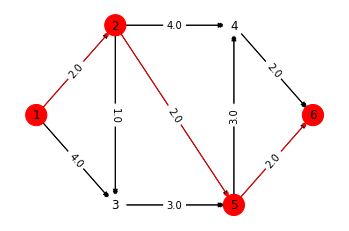

In [14]:
# We then set the coordinates of each node
G1.node[1]['pos'] = (0,0)
G1.node[2]['pos'] = (2,2)
G1.node[3]['pos'] = (2,-2)
G1.node[4]['pos'] = (5,2)
G1.node[5]['pos'] = (5,-2)
G1.node[6]['pos'] = (7,0)
# The positions of each node are stored in a dictionary
node_pos=nx.get_node_attributes(G1,'pos')
# The edge weights of each arcs are stored in a dictionary
arc_weight=nx.get_edge_attributes(G1,'weight')
# Create a list of arcs in the shortest path using the zip command and store it in red edges
red_edges = list(zip(sp,sp[1:]))
# If the node is in the shortest path, set it to red, else set it to white color
node_col = ['white' if not node in sp else 'red' for node in G1.nodes()]
# If the edge is in the shortest path set it to red, else set it to white color
edge_col = ['black' if not edge in red_edges else 'red' for edge in G1.edges()]
# Draw the nodes
nx.draw_networkx(G1, node_pos,node_color= node_col, node_size=450)
# Draw the edges
nx.draw_networkx_edges(G1, node_pos,edge_color= edge_col)
# Draw the edge labels
nx.draw_networkx_edge_labels(G1, node_pos,edge_color= edge_col, edge_labels=arc_weight)
# Remove the axis
plt.axis('off')
# Show the plot
plt.show()

In [15]:
G1.clear()

## Problem 2
### Problem statement
In the transportation network, the inflow comes from the origin Node 1, and the outflow comes out at the destination Node 5. Each edge has weighed travel time. **What is the path's shortest travel time in the network from the designated origin to the designated destination?**

<img src="./prob2.jpg" style="zoom:50%" />

#### Decision Variables
  ##### Variables of path  $x_{i,j}$
* $x_{1,2}$= the path from node 1 to node 2 
* $x_{1,3}$= the path from node 1 to node 3
* $x_{2,3}$= the path from node 2 to node 3
* $x_{2,4}$= the path from node 2 to node 4
* $x_{4,3}$= the path from node 4 to node 3
* $x_{3,5}$= the path from node 3 to node 5

##### Parameters of travel time  $t_{i,j}$
* $t_{1,2}$= the path from node 1 to node 2
* $t_{1,3}$= the path from node 1 to node 3
* $t_{2,3}$= the path from node 2 to node 3
* $t_{2,4}$= the path from node 2 to node 4
* $t_{4,3}$= the path from node 4 to node 3
* $t_{3,5}$= the path from node 3 to node 5

#### Objective function
Minimize $Z = \sum t_{i,j}\cdot x_{i,j}$\
  i.e., $Z = t_{1,2}\cdot x_{1,2}+t_{1,3}\cdot x_{1,3}+t_{2,3}\cdot x_{2,3}+t_{2,4}\cdot x_{2,4}+t_{4,3}\cdot x_{4,3}+t_{3,5}\cdot x_{3,5}$

#### Node constraints
* Origin: Node 1 \
$ 1 = x_{1,2}+x_{1,3}$
* Destination: Node 1 \
$ x_{3,5} = 1 $
* Node 2\
$x_{1,2}= x_{2,3}+ x_{2,4}$
* Node 3\
$x_{1,3}+ x_{2,3}+x_{4,3} = x_{3,5}$
* Node 4\
$x_{2,4} = x_{4,3}$


### Method 1 : Solution by Python Pulp Package

Initialize the network, build the nodes and edges. 

In [16]:
# Import PuLP modeler functions
from pulp import *
# Data for Linear Optimization Problem
N = 5  # Number of nodes in network
M = 2  # number of end nodes (source and sink or origin and destination)
INT = 3 # Number of intermediate nodes
a = range(1, N+1)
al = range(N)
b = range(1,N+1)
bl = range(N)
# Index list for decision variables x
xindx = [(a[i],b[j]) for j in bl for i in al]
T = INT + M # number of artificial variables (y)
tindx = range(1, T+1)

Define decision variables and objective function

In [17]:
model = LpProblem("Shortest Path Problem",LpMinimize)
# Decision variables
x = LpVariable.dicts("X", xindx,0,None)
y = LpVariable.dicts("Y", tindx,0,None)
model+= 2.0*x[1,2] + 8.0*x[1,3] + 5.0*x[2,3] + 2.0*x[2,4] + 1.0*x[4,3] + 1.0*x[3,5], "Transportation cost"

Add constraints on each node

In [18]:
model += x[1,2] + x[1,3] -y[1] == 1,"Source node"
model += x[3,5] - y[2] == 1,"Destination node"
model += x[1,2] - x[2,3] - x[2,4] - y[3] == 0,"Node 2"
model += x[1,3] + x[2,3] + x[4,3] -x[3,5]- y[4] == 0,"Node 3"
model += x[2,4] - x[4,3] - y[5] == 0, "Node 4"

Solve the model and find out the shortest path

In [19]:
model.solve()
print('Status:',LpStatus[model.status])

Status: Optimal


In [20]:
for v in model.variables():
    if v.varValue==1:
        print(v.name, '=', v.varValue)

X_(1,_2) = 1.0
X_(2,_4) = 1.0
X_(3,_5) = 1.0
X_(4,_3) = 1.0


The shortest path from node_1 to node_6 is 1->2->4->3->5

In [21]:
#Print the optimized value of the objective function
print('Objective Function',value(model.objective))

Objective Function 6.0


## Method 2: Solution by Python NetworkX Package

NetworkX is a python package which can be used for network analysis.

In [22]:
import networkx as nx

Initialize the network

In [23]:
# Initialize two empty directed graph objects
G1=nx.DiGraph()
G2=nx.DiGraph()
# An empty undirected path graph object can be initialized using the command
# G=nx.Graph()

G1-the first method to build nodes and weighed edges

In [24]:
G1.add_node(1)
G1.add_node(2)
G1.add_node(3)
G1.add_node(4)
G1.add_node(5)
G1.nodes()

NodeView((1, 2, 3, 4, 5))

In [25]:
G1.add_edge(1,2,weight=2)
G1.add_edge(1,3)
G1[1][3]['weight'] = 8
G1.add_edge(2,4,weight=2)
G1.add_edge(4,3,weight=1)
G1.add_edge(2,3)
G1[2][3]['weight'] = 5
G1.add_edge(3,5,weight=1)
G1.edges()

OutEdgeView([(1, 2), (1, 3), (2, 4), (2, 3), (3, 5), (4, 3)])

G2 - the second method to build nodes and weighed edges

In [26]:
list_nodes = [1,2,3,4,5]
G2.add_nodes_from(list_nodes)
G2.nodes()

NodeView((1, 2, 3, 4, 5))

In [27]:
list_arcs=[(1,2,2.0),(1,3,8.0),(2,3,5.0),(2,4,2.0),(2,3,1.0),(4,3,1.0),(3,5,1.0)]
G2.add_weighted_edges_from(list_arcs)
G2.edges()

OutEdgeView([(1, 2), (1, 3), (2, 3), (2, 4), (3, 5), (4, 3)])

Solve the proble with dijkstra method - weighed shortest path

In [28]:
sp=nx.dijkstra_path(G1,source=1,target=5)
print('The shortest dijkstra path (weighted path) is',sp)

The shortest dijkstra path (weighted path) is [1, 2, 4, 3, 5]


Solve the problem with BFS method - unweighed shortest path

In [29]:
print('The shortest path (unweighted) is ',nx.shortest_path(G1,source=1,target=5)) 

The shortest path (unweighted) is  [1, 3, 5]


Plot the network, mark the shortest path.

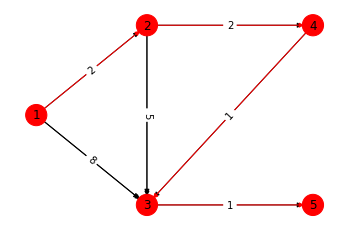

In [30]:
# We then set the coordinates of each node
G1.node[1]['pos'] = (0,0)
G1.node[2]['pos'] = (2,2)
G1.node[3]['pos'] = (2,-2)
G1.node[4]['pos'] = (5,2)
G1.node[5]['pos'] = (5,-2)
# The positions of each node are stored in a dictionary
node_pos=nx.get_node_attributes(G1,'pos')
# The edge weights of each arcs are stored in a dictionary
arc_weight=nx.get_edge_attributes(G1,'weight')
# Create a list of arcs in the shortest path using the zip command and store it in red edges
red_edges = list(zip(sp,sp[1:]))
# If the node is in the shortest path, set it to red, else set it to white color
node_col = ['white' if not node in sp else 'red' for node in G1.nodes()]
# If the edge is in the shortest path set it to red, else set it to white color
edge_col = ['black' if not edge in red_edges else 'red' for edge in G1.edges()]
# Draw the nodes
nx.draw_networkx(G1, node_pos,node_color= node_col, node_size=450)
# Draw the node labels
# nx.draw_networkx_labels(G1, node_pos,node_color= node_col)
# Draw the edges
nx.draw_networkx_edges(G1, node_pos,edge_color= edge_col)
# Draw the edge labels
nx.draw_networkx_edge_labels(G1, node_pos,edge_color= edge_col, edge_labels=arc_weight)
# Remove the axis
plt.axis('off')
# Show the plot
plt.show()